# Lumen Data Science

PyTissue

Update or install important libraries

In [3]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [4]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
from IPython.utils import io
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Label getters

In [5]:
train_path = Path("../Dataset/Dataset/IRMAS_Training_Data")
valid_path = Path("../Dataset/Dataset/IRMAS_Validation_Data")
test_path = Path("../Dataset/Dataset/IRMAS_Test_Data")
grand_path = Path("../Dataset/Dataset")

In [6]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#636) [Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-11.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-12.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-13.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-14.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-15.wav')]


In [7]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
def is_IRMAS_test(pat: Path):
    return str(pat).find("IRMAS_Test_Data") != -1

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [6]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [7]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [8]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    return get_IRMAS_valid_label(pat)

def get_single_label(pat: Path):
    return get_label(pat)[:1]

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Analyze the dataset

In [9]:
avg = np.average([len(get_label(f)) for f in get_song_files(valid_path)])

# Average accuracy when model outputs only zeros
all_z_ac = 1 - avg/11
print("All zeros model:", all_z_ac)

# If model can classify one instrument with accuracy
# of ac, then total accuracy will be less than:
ac = 0.95
one_l_ac = ac * (1 - (avg - 1)/11) + (1-ac) * (1 - (avg + 1)/11)
print("One label model:", one_l_ac)

# That means our model needs to have much bigger accuracy 
# than the first and we would strive for the second

All zeros model: 0.838336192109777
One label model: 0.9201543739279587


## Get items

In [10]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [11]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]

In [63]:
class RandomClip(Transform):
    split_idx=0
    def encodes(self, clip):
        maxran = len(clip)-sample_rate*3 + 1
        if maxran <= 0: maxran = 1

        i = np.random.randint(maxran)
        # i=0
        clip = clip[i:i+sample_rate*3]

        aplen = sample_rate*3 - len(clip)
        if aplen < 0: aplen = 0
        clip = np.concatenate([clip, np.zeros(aplen, dtype="float32")])

        return clip
        
class CenterClip(Transform):
    split_idx=1
    def encodes(self, clip):
        i = int((len(clip) - sample_rate*3) / 2)
        clip = clip[i:i+sample_rate*3]

        aplen = sample_rate*3 - len(clip)
        if aplen < 0: aplen = 0
        clip = np.concatenate([clip, np.zeros(aplen, dtype="float32")])
        return clip

random_clip = RandomClip().encodes
center_clip = CenterClip().encodes

In [13]:
def get_stft(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    return stft

In [14]:
def get_spec(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return S_db

In [15]:
def get_mag(clip):
    M = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

<Figure size 640x480 with 0 Axes>

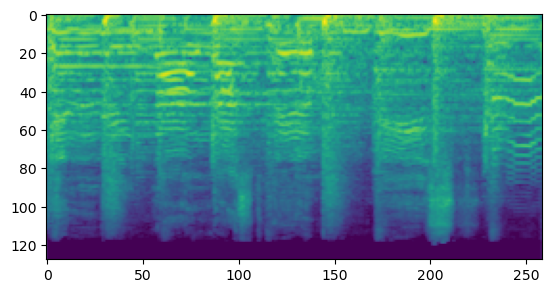

In [67]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")

spec = get_spec(center_clip(get_song(song_path)))
plot.figure()
# plot.imshow(spec)
spec = get_mag(center_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)

## Metrics

In [42]:
def AccuracyMulti(tresh=0.5):
    def acc(x, y):
        return 1 - (((x > tresh).float() - y).abs()).float().mean()
    return acc
AccuracyMulti()(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [43]:
get_song_tfms = [get_song, RandomClip(), CenterClip()]
get_label_tfms = [get_label, MultiCategorize(), OneHotEncode()]
get_single_label_tfms = [get_single_label, Categorize()]

get_spec_tfms = [get_spec, PILImage.create]
get_mag_tfms = [get_mag, PILImage.create]

In [44]:
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(x)[0]]

In [45]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, augm=[], num=1, perc=0.5):
        self.items = np.array(items)
        self.get_song_pipe = Pipeline(get_song_tfms)
        self.augm_pipe = Pipeline(augm)
        self.get_label_pipe = Pipeline(get_label_tfms)
        self.num = num
        self.perc = perc
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        self.augm_pipe.split_idx = 0
        self.get_song_pipe.split_idx = 0
        X = [self.augm_pipe([self.get_song_pipe(f)])[0] for f in files]
        Y = [self.get_label_pipe(f) for f in files]
        return X, Y
        
    def encodes(self, item):
        if np.random.rand() >= self.perc: return item
        x, y = item
        l = np.random.poisson(self.num)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        x = sum(X)
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [46]:
class RandomRotate(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(self.l*sample_rate)
        i = np.random.randint(-maxran, maxran+1)
        x = np.roll(x, i)
        return [x] + item[1:]

In [47]:
class RandomEdgeSilence(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(sample_rate*self.l)
        i = np.random.randint(-maxran, maxran+1)
        if i < 0: x[i:] = 0
        else: x[:i] = 0
        return [x] + item[1:]

In [48]:
class RandomAmp(ItemTransform):
    split_idx = 0
    def __init__(self, rng=[0.6,2]):
        self.rng = rng
    def encodes(self, item):
        x = item[0]
        x = x * np.random.uniform(self.rng[0], self.rng[1])
        return [x] + item[1:]

In [49]:
class ToSpec(ItemTransform):
    def __init__(self, tfms):
        self.pipe = Pipeline(tfms)
    def encodes(self, item):
        x = item[0]
        return [self.pipe(x)] + item[1:]

In [50]:
class ShowSong(ItemTransform):
    split_idx = 0
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item

In [51]:
def get_dataset(items, splitter=RandomSplitter()):
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, get_label_tfms], splits=splits)

In [52]:
irmas_splitter = FuncSplitter(lambda x: is_IRMAS_test(x))
irmas_splitter(get_song_files(grand_path))

((#7341) [2238,2239,2240,2241,2242,2243,2244,2245,2246,2247...],
 (#2238) [0,1,2,3,4,5,6,7,8,9...])

In [53]:
items = get_song_files(grand_path)
train_dset = get_dataset(items, irmas_splitter)
augm_items = get_song_files(train_path) # [train_dset.items[i] for i in train_dset.splits[0]]

augm = [
    RandomRotate(l=1.5),
    RandomEdgeSilence(l=1),
    RandomAmp(rng=[0.8,1.2])
]
after_augm = [
    AddRandomSongs(augm_items, augm=augm, num=2.5),
    ShowSong(3),
    ToSpec(get_spec_tfms),
    Resize((256, 156), method=ResizeMethod.Squish),
]

def get_dataloader(ds, augm=augm, after_augm=after_augm):
    after_item = augm + after_augm + [ToTensor(), IntToFloatTensor()]
    return ds.dataloaders(bs=64, after_item=after_item, shuffle=True)

TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

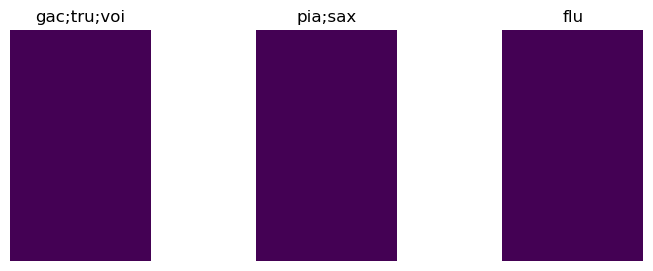

In [54]:
dls = get_dataloader(train_dset)
dls.show_batch(max_n=3)

In [55]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
print(dls.vocab)
print(len(dls.vocab))

7341
2238
['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
11


In [56]:
# learn = vision_learner(dls, lambda **args: learn_backup.model, metrics=AccuracyMulti(tresh=0.8)) 
learn = vision_learner(dls, resnet18, pretrained=True, metrics=AccuracyMulti(tresh=0.8))
# valid 
# no valid 0.878

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [283]:
learn.fine_tune(10)

In [57]:
# learn.save('SNGCLA_model')

In [43]:
interp = Interpretation.from_learner(learn)

In [58]:
# interp.p lot_top_losses(10)

In [221]:
_, idxs = interp.top_losses(3)

for pat in np.array(dls.valid_ds.items)[idxs]:
    print(pat)
    print("Target:", get_label(pat))
    print("Preds")
    display(Audio(data=get_song(pat), rate=sample_rate))
    

../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-12.wav
Target: ['gac', 'gel', 'org', 'pia', 'voi']
Preds


../Dataset/Dataset/IRMAS_Test_Data/Jaga Jazzist - Mikado-21.wav
Target: ['gac', 'gel', 'tru', 'voi']
Preds


../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-9.wav
Target: ['gac', 'gel', 'org', 'pia', 'voi']
Preds


## Track GPU usage

In [59]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [60]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [61]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [62]:
report_gpu()

Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Test on Validation data

In [108]:
for i in range(2):
    test_items = get_song_files(test_path)
    tdset = dls.test_dl(test_items, with_labels=True)
    print(learn.validate(dl=tdset))

KeyboardInterrupt: 

In [255]:
tdset = dls.test_dl(test_items, with_labels=False)
learn.get_preds(dl=tdset)

(TensorBase([[0.2084, 0.0854, 0.1633,  ..., 0.0414, 0.1784, 0.3077],
             [0.0507, 0.0667, 0.0477,  ..., 0.0582, 0.0500, 0.9998],
             [0.0205, 0.0749, 0.0417,  ..., 0.0253, 0.0200, 1.0000],
             ...,
             [0.1164, 0.1894, 0.3628,  ..., 0.0736, 0.1653, 0.0040],
             [0.1301, 0.1289, 0.2777,  ..., 0.1302, 0.1493, 0.0060],
             [0.1703, 0.0534, 0.0926,  ..., 0.1249, 0.1573, 0.0036]]),
 None)

In [68]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav")
song = center_clip(get_song(song_path))
learn.predict(song)[1]

TensorBase([False, False, False, False, False, False, False, False,  True,
             True,  True])

In [69]:
def get_preds(learn, song, step=sample_rate):
    res = np.array([0]*len(learn.dls.vocab))
    rang = range(0, len(song)-sample_rate*3, step)
    for i in rang:
        short = song[i:i+sample_rate*3]
        with io.capture_output() as captured:
            res = res + L(learn.predict(short)[1].storage())
    preds = []
    for i, inst in enumerate(learn.dls.vocab):
        if res[i] > len(rang) * 0.2:
            preds.append(inst)
    return preds

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-3.wav")
song = get_song(song_path)
preds = get_preds(learn, song)
print(preds)

['tru', 'vio', 'voi']


In [70]:
# Paralelize this!!!!
def validate(learn):
    mistakes = dict((v, 0) for v in learn.dls.vocab)
    test_files = get_song_files(test_path)
    print("0%", end="")
    for i, file in enumerate(test_files):
        song = get_song(file)
        target_label = set(get_label(file))
        pred_label = set(get_preds(learn, song))
        false_label = target_label.symmetric_difference(pred_label)
        for m in false_label:
            mistakes[m] += 1
        print(f"\r{int(100 * i / len(test_files))}%", end="")
    print()
    for m in mistakes:
        mistakes[m] /= len(test_files)
    return mistakes

In [110]:
def get_sl_windows(song, step=sample_rate):
    for i in range(0, len(song)-sample_rate*3, step):
        yield song[i:i+sample_rate*3]

In [ ]:
Datasets(items, [get_song_tfms, ], split_idx=1)

In [148]:
preds = tensor([[0., 0., 0.,   0., 0., 0.],
         [0., 0., 0.,   0., 0., 1.],
         [0., 0., 0.,   0., 0., 1.],
         [0., 0., 1.,   0., 0., 0.],
         [0., 0., 1.,   0., 0., 0.],
         [0., 0., 0.,   0., 0., 0.]])
learn.dls.vocab[sum(preds[[1,4]]) >= 1]

(#2) ['flu','org']

In [139]:
learn.get_preds(dl=tdset, with_targs=True)[0]

(TensorBase([[0.0716, 0.0091, 0.0100,  ..., 0.3712, 0.9935, 0.9356],
             [0.3137, 0.0235, 0.0404,  ..., 0.4446, 0.9678, 0.9709],
             [0.2060, 0.0152, 0.0285,  ..., 0.4912, 0.9923, 0.9718],
             ...,
             [0.2416, 0.0370, 0.0337,  ..., 0.5825, 0.9387, 0.9524],
             [0.2323, 0.0336, 0.0281,  ..., 0.5774, 0.9163, 0.9322],
             [0.0919, 0.0070, 0.0516,  ..., 0.6937, 0.9914, 0.9602]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [1]:
def validate(learn):
    test_items = []
    song_idxs = {}
    for i, file in enumerate(get_song_files(test_path)):
        song_idxs[file] = []
        for sl in get_sl_windows(get_song(file)):
            test_items.append(sl)
            song_idxs[file].append(len(test_items)-1)
    print("Created dataset")
    valid_dls = learn.dls.new_empty()
    valid_dls.tfms = L([Pipeline([lambda o: o]), valid_dls.tfms[1]])
    valid_dls = dls.test_dl(test_items, with_labels=False)
    print("Created dataloaders")
    preds = learn.get_preds(dl=tdset, with_targs=True)[1]
    print("Predictions")
    
    mistakes = dict((v, 0) for v in learn.dls.vocab)
    for pat in song_idxs:
        pred_label = set(learn.dls.vocab[sum(preds[song_idxs[pat]]) >= len(song_idxs[pat]) * 0.3])
        target_label = set(get_label(file))
        for m in target_label.symmetric_difference(pred_label):
            mistakes[m] += 1
        
    for m in mistakes:
        mistakes[m] /= len(test_files)
    return mistakes
    

In [2]:
validate(learn)

NameError: name 'learn' is not defined

In [71]:
from datetime import datetime

def train(arch=resnet18, spec_tfms=get_spec_tfms, info= "...", tresh=0.8, epochs=16):
    print("Setup:")
    print(info)
    print(arch, spec_tfms)
    
    augm = [
        RandomRotate(l=1.5),
        RandomEdgeSilence(l=1),
        RandomAmp(rng=[0.8,1.2])
    ]
    after_augm = [
        AddRandomSongs(augm_items, augm=augm, num=2.5),
        ToSpec(spec_tfms),
        Resize((256, 156), method=ResizeMethod.Squish),
    ]
    dls = get_dataloader(train_dset, augm=augm, after_augm=after_augm)
    learn = vision_learner(dls, arch, pretrained=True, metrics=AccuracyMulti(tresh=tresh))
    learn.fine_tune(epochs)
    print(validate(learn))
    
    tim = datetime.now().strftime("%H_%M_%S")
    print(learn.save(f'{tim}_model'))
    report_gpu()

In [72]:
# avg all zeros 0.844467
# train(resnet18, tfms=get_spec_tfms, info="Resnet18 - with spectogram") # 0.844468
# train(resnet18, spec_tfms=get_mag_tfms, info="Resnet18 - with magspectogram", epochs=1) # 0.861833
train(squeezenet1_0, info="squeezenet1_0 - with magspectogram", epochs=1) # 862023
train(densenet121, info="densenet121 - with magspectogram", epochs=1) # 0.844468
train(vgg16_bn, info="vgg16_bn - with magspectogram", epochs=1) # 0.871576
train(alexnet, info="alexnet - with magspectogram", epochs=1) # 0.858227

Setup:
squeezenet1_0 - with magspectogram
<function squeezenet1_0 at 0x7f3e90ba8dc0> [<function get_spec at 0x7f3e908372e0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


49%

KeyboardInterrupt: 

## Gradient Accumulation

In [ ]:
# def train2(arch, accum=1, finetune=True, epochs=12, bs=64):
#     _dls = DataBlock(
#         blocks = [ImageBlock(), MultiCategoryBlock],
#         get_items = get_song_files,
#         splitter = RandomSplitter(),
#         get_x = get_magspec,
#         get_y = get_label
#     ).dataloaders(path, bs=bs)
#     cbs = GradientAccumulation(64) if accum else []
#     learn = vision_learner(_dls, arch, metrics=acc, cbs=cbs).to_fp16()
#     if finetune:
#         learn.fine_tune(epochs, 0.01)
#         # return learn.tta(dl=dls.test_dl(tst_files))
#     else:
#         learn.unfreeze()
#         learn.fit_one_cycle(epochs, 0.01)